In [34]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torch import optim
from torch import nn
from torchvision import datasets
from torchvision import transforms as tr
import os
import sys
from tqdm import tqdm
import wandb
import torch_optimizer

In [22]:
project_root = 'C:/Users/rlduf/Desktop/GitHub/DeepLearning/sam'
sys.path.append(project_root)
data_root = os.path.join(project_root, 'data')

In [23]:
from data_utils import dataset_split

In [24]:
transform = tr.Compose([
    tr.ToTensor(),
    tr.Normalize([0.5], [0.5])
])

In [25]:
cifar10_dataset = datasets.CIFAR10(
    root=data_root,
    download=True,
    train=True,
    transform=transform
)

Files already downloaded and verified


In [26]:
datasets = dataset_split(cifar10_dataset, split=[0.8, 0.2])

train_data = datasets['train']
val_data = datasets['val']

train_batch_size = 64
val_batch_size = 64

train_dataloader = DataLoader(
    train_data, batch_size=train_batch_size, shuffle=True, num_workers=1
)

val_dataloader = DataLoader(
    val_data, batch_size=val_batch_size, shuffle=False, num_workers=1
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


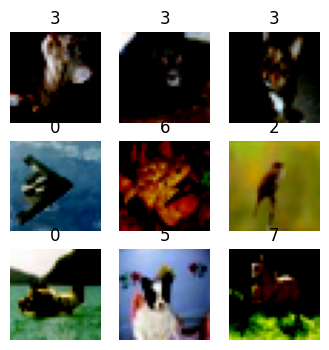

In [27]:
rows, cols = 3,3
figure = plt.figure(figsize=(4,4))

for i in range(1, rows*cols+1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.imshow(img.permute(1,2,0))
    plt.axis('off')
plt.show()

In [28]:
class MLP(nn.Module):
    def __init__(self, in_dim:int, h1_dim:int, h2_dim:int, h3_dim:int, out_dim:int):
        super(MLP, self).__init__()
        self.relu = nn.ReLU()
        self.linear1 = nn.Linear(in_dim, h1_dim)
        self.linear2 = nn.Linear(h1_dim, h2_dim)
        self.linear3 = nn.Linear(h2_dim, h3_dim)
        self.linear4 = nn.Linear(h3_dim, out_dim)
        self.flatten = nn.Flatten()

    def forward(self, X):
        X = self.flatten(X)
        X = self.relu(self.linear1(X))
        X = self.relu(self.linear2(X))
        X = self.relu(self.linear3(X))
        logits = self.linear4(X)
        return logits

In [36]:
class MLPDropout(MLP):
    def __init__(self, in_dim:int, h1_dim:int, h2_dim:int, h3_dim:int, out_dim:int, prob:float):
        super(MLPDropout, self).__init__(in_dim, h1_dim, h2_dim, h3_dim, out_dim)
        self.dropout1 = nn.Dropout(p=prob)
        self.dropout2 = nn.Dropout(p=prob)
        self.dropout3 = nn.Dropout(p=prob)

    def forward(self, input):
        X = self.flatten(input)
        X = self.relu(self.linear1(X))
        X = self.dropout1(X)
        X = self.relu(self.linear2(X))
        X = self.dropout2(X)
        X = self.relu(self.linear3(X))
        X = self.dropout3(X)
        logits = self.linear4(X)
        return logits

In [37]:
class WarmupLR(optim.lr_scheduler.LambdaLR):
    def __init__(self, optimzier:optim.Optimizer, warmup_end_step:int, last_epoch:int=-1):
        def warmup_fn(step:int):
            if step < warmup_end_step:
                return step / warmup_end_step
            else:
                return 1.0
        super(WarmupLR, self).__init__(optimzier, warmup_fn, last_epoch)

In [38]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [39]:
model = MLPDropout(in_dim = 3*32*32, h1_dim = 512, h2_dim = 256, h3_dim = 128, out_dim = 10, prob = 0.2).to(device)
model_name = type(model).__name__

loss_fn = nn.CrossEntropyLoss()

learning_rate = 1e-4
optimizer = torch_optimizer.RAdam(model.parameters(), lr=learning_rate)
optimizer_name = type(optimizer).__name__

scheduler = WarmupLR(optimizer, 1500)
scheduler_name = type(scheduler).__name__

num_epoch = 30

log_dir = f'{model_name}-{optimizer_name}-{learning_rate}-{scheduler_name}'
log_model_path = os.path.join(log_dir, 'models')
os.makedirs(log_model_path, exist_ok=True)

project_name = 'cifar10'
run_tag = [project_name]
wandb.init(
    project=project_name,
    name=log_dir,
    tags=run_tag,
    config={"lr": learning_rate, "model_name": model_name, "optimizer_name": optimizer_name, "scheduler_name": scheduler_name},
    reinit=True,
)

In [49]:
train_step = 0
for epoch in range(1, 2):
    # valid step
    with torch.no_grad():
        val_loss = 0.0
        val_corrects = 0
        model.eval()

        a, b = 0,0

        for val_batch_idx, (val_images, val_labels) in enumerate(
            tqdm(val_dataloader, position=0, leave=True, desc="validation")
        ):
            val_images, val_labels = val_images.to(device), val_labels.to(device)

            # forward
            val_outputs = model(val_images) # 64 x 10
            _,  val_preds = torch.max(val_outputs, 1) # 64개의 index
            
            # loss & acc
            val_loss += loss_fn(val_outputs, val_labels) / val_outputs.shape[0]
            val_corrects += torch.sum(val_preds == val_labels) / val_outputs.shape[0]


            a += loss_fn(val_outputs, val_labels).item()
            b += (val_outputs.argmax(1)==val_labels).type(torch.float).sum().item()
    
    # valid step logging
    val_epoch_loss = val_loss / len(val_dataloader)
    val_epoch_acc = val_corrects / len(val_dataloader)

    a /= len(val_dataloader)
    b /= len(val_dataloader.dataset)

    print(
        f"{epoch} epoch, {train_step} step: val_loss: {val_epoch_loss}, val_acc: {val_epoch_acc}"
    )

    print(
        f"{epoch} epoch, {train_step} step: val_loss: {a}, val_acc: {b}"
    )

validation: 100%|██████████| 157/157 [00:03<00:00, 43.18it/s]

1 epoch, 0 step: val_loss: 0.036675456911325455, val_acc: 0.08091162890195847
1 epoch, 0 step: val_loss: 2.3034528319243415, val_acc: 0.0807
